 # Chapter 0: Preparation
 Importing Neccessary Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

Defining all formulas used for future visualization

In [2]:
def unit_summation (df, preferences):
    names = df['name'].tolist()
    preferences = preferences.loc[preferences['name'].isin(names)]
    df_counts = preferences.iloc[:,1:].apply(pd.Series.value_counts).fillna(0)
    df_counts['Sum'] = df_counts.sum(axis=1)
    return df_counts.sort_values(by=['Sum', 'unit0'], ascending=False)['Sum']


def unit_comparison(df1, df2, preferences):
    counts_1 = unit_summation(df1, preferences)
    counts_2 = unit_summation(df2, preferences)
    return pd.concat([counts_1, counts_2], axis=1).fillna(0)


def make_bar_plot(df):
    columns = df.columns
    series = pd.Series(data=df[columns[0]].to_numpy(), index=df[columns[1]].to_numpy())
    plot = series.plot(kind='barh')
    plot.invert_yaxis()
def make_histogram(df, bins):
    columns = df.columns
    column = df[columns[0]].to_numpy()
    plt.hist(column, edgecolor ='black', bins=bins)
    plt.show()


Importing the json files acquired from web scraping. 

In [3]:
units = pd.read_json('units.json')
players = pd.read_json('players.json')
profiles = pd.read_json('profiles.json')
preferences = pd.read_json('unit_choices.json')

#  Chapter 1: Data Preprocessing


## Data Prepreocessing for Unit Data

This is what the current dataframe called 'units' looks like. The units dataframe contains the playrate and the average placement of each TFT unit for the current patch (12.8) and the previous patch (12.7). However, the dataset currently states that all the entries are from the current patch. Also worth noting that the playrate is from a scale of 8. In this case, Brand is used by 0.49 of the 8 players on average every game. The unit's name and cost is also included in the table.

In [4]:
pd.concat([units.head(), units[59:64], units.tail()])

,unit,playrate,placement,patch,cost
0,Brand,0.49,4.61,current,1
1,Caitlyn,0.49,4.64,current,1
2,Camille,0.84,4.50,current,1
3,Darius,0.72,4.34,current,1
4,Ezreal,0.86,4.51,current,1
59,Zeri,0.92,4.00,current,5
60,Brand,0.58,4.63,current,1
61,Caitlyn,0.52,4.61,current,1
62,Camille,0.80,4.56,current,1
63,Darius,0.50,4.60,current,1


In [5]:
units[59:64]

,unit,playrate,placement,patch,cost
59,Zeri,0.92,4.00,current,5
60,Brand,0.58,4.63,current,1
61,Caitlyn,0.52,4.61,current,1
62,Camille,0.80,4.56,current,1
63,Darius,0.50,4.60,current,1


From knowledge of how the json file was extracted, entries 1 to 59 are from the current patch, while 60-119 are from the previous patch. As a result, entries 60 to 119 are updated to show patch 12.7, then the dataframes are separated.

In [6]:
duplicate_indices = [i for i in range(60, 120)]
for index in duplicate_indices:
    units.at[index, 'patch'] = '12.7'
old = units[units["patch"] == '12.7']
current = units[units["patch"] != '12.7']
pd.concat([current.head(), old.head()])


,unit,playrate,placement,patch,cost
0,Brand,0.49,4.61,current,1
1,Caitlyn,0.49,4.64,current,1
2,Camille,0.84,4.50,current,1
3,Darius,0.72,4.34,current,1
4,Ezreal,0.86,4.51,current,1
60,Brand,0.58,4.63,12.7,1
61,Caitlyn,0.52,4.61,12.7,1
62,Camille,0.80,4.56,12.7,1
63,Darius,0.50,4.60,12.7,1
64,Ezreal,0.92,4.29,12.7,1


Merge/Join the two dataframes on the column 'unit'.


In [7]:
joined_units = pd.merge(old, current, on="unit")
joined_units.head()

,unit,playrate_x,placement_x,patch_x,cost_x,playrate_y,placement_y,patch_y,cost_y
0,Brand,0.58,4.63,12.7,1,0.49,4.61,current,1
1,Caitlyn,0.52,4.61,12.7,1,0.49,4.64,current,1
2,Camille,0.80,4.56,12.7,1,0.84,4.50,current,1
3,Darius,0.50,4.60,12.7,1,0.72,4.34,current,1
4,Ezreal,0.92,4.29,12.7,1,0.86,4.51,current,1


Cleaning column names and dropping unused columns:

In [8]:
joined_units.rename(columns = {'playrate_x': '12.7 Playrate', 'placement_x': '12.7 Placement', 'playrate_y': '12.8 Playrate', 'placement_y': '12.8 Placement', 'cost_y': 'Cost'}, inplace=True)
joined_units.drop(['patch_x', 'patch_y', 'cost_x'], axis=1, inplace=True)
joined_units.head()

,unit,12.7 Playrate,12.7 Placement,12.8 Playrate,12.8 Placement,Cost
0,Brand,0.58,4.63,0.49,4.61,1
1,Caitlyn,0.52,4.61,0.49,4.64,1
2,Camille,0.80,4.56,0.84,4.50,1
3,Darius,0.50,4.60,0.72,4.34,1
4,Ezreal,0.92,4.29,0.86,4.51,1


Making a new column showing the difference in playrate/placement by unit. Playrate is also adjusted to a percentage value as mentioned prior.  

In [9]:
joined_units['12.7 Playrate'] = joined_units['12.7 Playrate'] * (100/8)
joined_units['12.8 Playrate'] = joined_units['12.8 Playrate'] * (100/8)
joined_units['playrate_change'] = joined_units['12.8 Playrate'] - joined_units['12.7 Playrate']
joined_units['placement_change'] = joined_units['12.8 Placement'] - joined_units['12.7 Placement']
joined_units.head()

,unit,12.7 Playrate,12.7 Placement,12.8 Playrate,12.8 Placement,Cost,playrate_change,placement_change
0,Brand,7.25,4.63,6.125,4.61,1,-1.125,-0.02
1,Caitlyn,6.50,4.61,6.125,4.64,1,-0.375,0.03
2,Camille,10.00,4.56,10.500,4.50,1,0.500,-0.06
3,Darius,6.25,4.60,9.000,4.34,1,2.750,-0.26
4,Ezreal,11.50,4.29,10.750,4.51,1,-0.750,0.22


## Data Prepreocessing for Profile Data

This is what the dataframe titled 'profiles' currently looks like, obtained from web scraping inviduals profiles on the site tactics.tools. Contains the user and a set of ratings made by the site. The dataframe titled 'players' contains summary stats of the top 40 players on the leaderboard on tactics.tools/leaderboards/na at the time the site was scraped (May 7, 2022). It's worth noting not every profil was able to be scraped. 

In [10]:
profiles.head()

,Compositions,Econ,Flexibility,Execution,Items,name
0,S+,S+,C,A,B,Dishsoap2
1,S+,S+,C,S,A,Amde
2,S+,S,A,A,A,BestSatoJP
3,S+,A,F,S,S,CN smùrfing
4,S+,A,A,A,A,Triple8s


In [11]:
players.head()

,rank,name,patch-lp,lp,patch-games,games,link
0,1,sètsuko,-29,1662,62,641,/player/na/s%C3%A8tsuko
1,2,Wíthin,-35,1639,34,375,/player/na/W%C3%ADthin
2,3,Darth Nub,397,1606,56,580,/player/na/Darth%20Nub
3,4,Subha,713,1604,69,434,/player/na/Subha
4,6,tapiokaoisii,117,1527,106,323,/player/na/tapiokaoisii


The column 'link' was used for getting a list of profiles to scrape from for the 'profiles' dataframe. It will be dropped as it's no longer needed.

In [12]:
players.drop('link', axis=1, inplace=True)
players.head()

,rank,name,patch-lp,lp,patch-games,games
0,1,sètsuko,-29,1662,62,641
1,2,Wíthin,-35,1639,34,375
2,3,Darth Nub,397,1606,56,580
3,4,Subha,713,1604,69,434
4,6,tapiokaoisii,117,1527,106,323


Join the two dataframes on name of user for overall data on each player. 

In [13]:
full_player_data = pd.merge(players, profiles, on='name')
full_player_data.head()

,rank,name,patch-lp,lp,patch-games,games,Compositions,Econ,Flexibility,Execution,Items
0,1,sètsuko,-29,1662,62,641,S+,S+,B,A,B
1,2,Wíthin,-35,1639,34,375,S+,S,C,S,S
2,3,Darth Nub,397,1606,56,580,S+,S+,A,S+,A
3,4,Subha,713,1604,69,434,S+,S+,A,S+,S
4,6,tapiokaoisii,117,1527,106,323,S+,S+,C,A,A


A number mapping to each of the gradings (S+, S, A, etc.) need to be given for sorting later on, so it is made and assigned here. 

In [14]:
df_mapping = pd.DataFrame({'grade': ['F', 'D', 'C', 'B', 'A', 'S', 'S+']})
sort_mapping = df_mapping.reset_index().set_index('grade')
del(df_mapping)
sort_mapping

,index
grade,
F,0
D,1
C,2
B,3
A,4
S,5
S+,6


In [15]:
categories = ['Econ', 'Execution', 'Items', 'Flexibility', 'Compositions']
leaderboard_data = ['patch-lp', 'patch-games']
for category in categories:
    full_player_data[category + '_num'] = full_player_data[category].map(sort_mapping['index'])
del(sort_mapping)
full_player_data.head()

,rank,name,patch-lp,lp,patch-games,games,Compositions,Econ,Flexibility,Execution,Items,Econ_num,Execution_num,Items_num,Flexibility_num,Compositions_num
0,1,sètsuko,-29,1662,62,641,S+,S+,B,A,B,6,4,3,3,6
1,2,Wíthin,-35,1639,34,375,S+,S,C,S,S,5,5,5,2,6
2,3,Darth Nub,397,1606,56,580,S+,S+,A,S+,A,6,6,4,4,6
3,4,Subha,713,1604,69,434,S+,S+,A,S+,S,6,6,5,4,6
4,6,tapiokaoisii,117,1527,106,323,S+,S+,C,A,A,6,4,4,2,6


The last dataframe to add to dataframe are the preferred units of each player at the top of the leaderboard. The dataframe titled 'preferences' contains a list of the seven most used units (in order) by the top ranked players on the North America Server at the end of games. This gives an idea of what units the best players look to use when building their final team composition. 

In [16]:
preferences.head()

,name,unit0,unit1,unit2,unit3,unit4,unit5,unit6
0,sètsuko,Braum,Orianna,Jinx,Kaisa,Silco,Jhin,Senna
1,Amde,Braum,Ekko,Silco,Jhin,Orianna,Jinx,Blitzcrank
2,tapiokaoisii,Silco,Viktor,Kaisa,Zac,Renata,Tahmkench,Malzahar
3,Wíthin,Jinx,Ekko,Silco,Viktor,Jayce,Renata,Orianna
4,BestSatoJP,Silco,Renata,Zac,Viktor,Seraphine,Ekko,Jinx


In [17]:
full_player_data = pd.merge(full_player_data,preferences, on= "name")
full_player_data.head()

,rank,name,patch-lp,lp,patch-games,games,Compositions,Econ,Flexibility,Execution,...,Items_num,Flexibility_num,Compositions_num,unit0,unit1,unit2,unit3,unit4,unit5,unit6
0,1,sètsuko,-29,1662,62,641,S+,S+,B,A,...,3,3,6,Braum,Orianna,Jinx,Kaisa,Silco,Jhin,Senna
1,2,Wíthin,-35,1639,34,375,S+,S,C,S,...,5,2,6,Jinx,Ekko,Silco,Viktor,Jayce,Renata,Orianna
2,3,Darth Nub,397,1606,56,580,S+,S+,A,S+,...,4,4,6,Silco,Jinx,Ekko,Viktor,Braum,Blitzcrank,Kaisa
3,4,Subha,713,1604,69,434,S+,S+,A,S+,...,5,4,6,Silco,Jinx,Braum,Blitzcrank,Irelia,Viktor,Ekko
4,6,tapiokaoisii,117,1527,106,323,S+,S+,C,A,...,4,2,6,Silco,Viktor,Kaisa,Zac,Renata,Tahmkench,Malzahar


# Chapter 2:Data Analysis

### Selecting Style of Visualizations

In [18]:
plt.style.use('fivethirtyeight')

## Analysis of Unit Data
### Glance at Unit Data

In [19]:
joined_units.head()

,unit,12.7 Playrate,12.7 Placement,12.8 Playrate,12.8 Placement,Cost,playrate_change,placement_change
0,Brand,7.25,4.63,6.125,4.61,1,-1.125,-0.02
1,Caitlyn,6.50,4.61,6.125,4.64,1,-0.375,0.03
2,Camille,10.00,4.56,10.500,4.50,1,0.500,-0.06
3,Darius,6.25,4.60,9.000,4.34,1,2.750,-0.26
4,Ezreal,11.50,4.29,10.750,4.51,1,-0.750,0.22


### Find the Biggest 'Winners' and 'Losers' of the Patch
This can be done by finding the top 10 biggest increases and decreases in both popularity, and success (average placement).

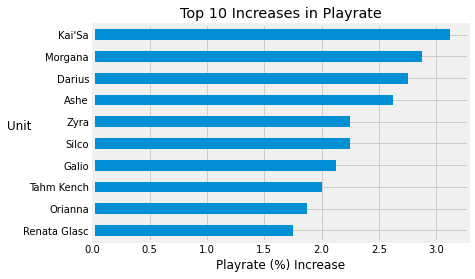

In [20]:
top_10 = joined_units.nlargest(n=10, columns=['playrate_change'])[['playrate_change', 'unit']]
make_bar_plot(top_10)
plt.title('Top 10 Increases in Playrate')
plt.xlabel('Playrate (%) Increase')
plt.ylabel('Unit',rotation=0)
plt.show()
# same was done for next plot

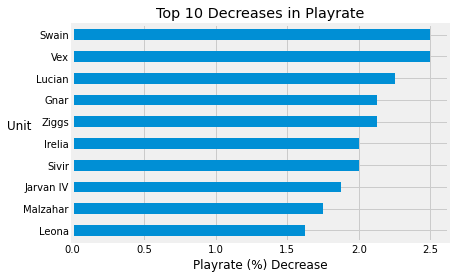

In [21]:
top_10 = joined_units.nsmallest(n=10, columns=['playrate_change'])[['playrate_change', 'unit']]
top_10['playrate_change'] = top_10['playrate_change'].abs()
make_bar_plot(top_10)
plt.title('Top 10 Decreases in Playrate')
plt.xlabel('Playrate (%) Decrease')
plt.ylabel('Unit',rotation=0)
plt.show()

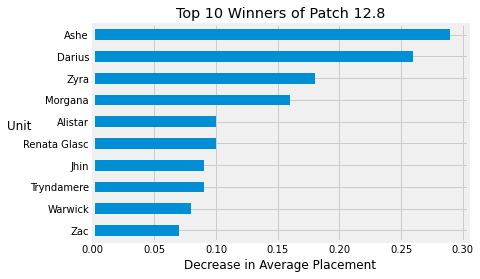

In [22]:
top_10 = joined_units.nsmallest(n=10, columns=['placement_change'])[['placement_change', 'unit']]
top_10['placement_change'] = top_10['placement_change'].abs()
make_bar_plot(top_10)
plt.title('Top 10 Winners of Patch 12.8')
plt.xlabel('Decrease in Average Placement')
plt.ylabel('Unit',rotation=0)
plt.show()

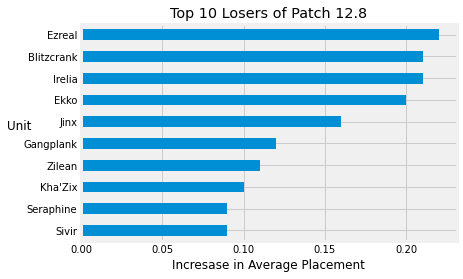

In [23]:
top_10 = joined_units.nlargest(n=10, columns=['placement_change'])[['placement_change', 'unit']]
make_bar_plot(top_10)
plt.title('Top 10 Losers of Patch 12.8')
plt.xlabel('Incresase in Average Placement')
plt.ylabel('Unit',rotation=0)
plt.show()

*Note that an increase in average placement means you're placing worse on average, while a decrease in average placement means you're placing better on average.  
### Top Units on Endgame Boards

In [24]:
joined_units.sort_values(by=['12.8 Playrate'],ascending=False)[['unit', '12.8 Playrate']].head()

,unit,12.8 Playrate
41,Braum,29.125
27,Ekko,25.125
46,Orianna,24.000
53,Jinx,23.000
29,Gnar,22.500


Despite units like Ekko, Jinx, and Blitzcrank dropping in playrate, they're still amongst the most played units in the game. How do other units fare in terms of popularity and success?

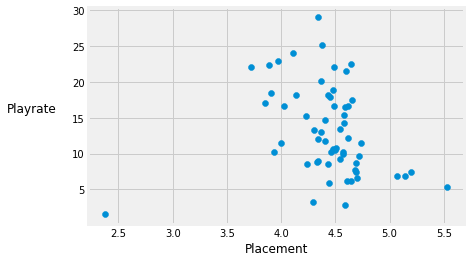

In [25]:
placement = joined_units['12.8 Placement']
playrate = joined_units['12.8 Playrate']
plt.scatter(placement,playrate)
plt.xlabel('Placement')
plt.ylabel('Playrate', rotation=0, labelpad=40)
plt.show()


There appears to be a large outlier with an average placement slightly below 2.5. That outlier is Veigar, a unit that cannot be bought and only appears under very specific conditions, we will drop Veigar for this visualization.

In [26]:
joined_units.sort_values(by=['12.8 Placement']).head(1)

,unit,12.7 Playrate,12.7 Placement,12.8 Playrate,12.8 Placement,Cost,playrate_change,placement_change
57,Veigar,1.5,2.31,1.5,2.38,5,0.0,0.07


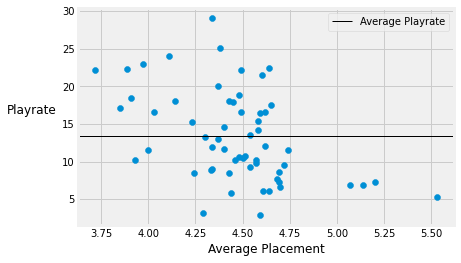

In [27]:
df = joined_units.drop(57)
mean = df['12.8 Playrate'].mean()
plt.scatter(df['12.8 Placement'], df['12.8 Playrate'])
plt.axhline(y=mean, color = 'black', label = 'Average Playrate', linewidth = 1)
plt.xlabel('Average Placement')
plt.ylabel('Playrate', rotation=0, labelpad=30)
plt.legend()

To get a better picture on the metagame and what people play, we'll focus only on the units above the average playrate threshold (13.38%), we get the resulting scatter plot, with the colors of the poitns representing the costs of the unit. The 5 costs units (ex. Silico, Jayce, Jinx) are towards the left of the plot, representing a better average placement. Braum, Ekko, and Orianna are the two most popular units, followed by Jinx and Gnar. Silico, Viktor, and Jayce are the best performing units in the patch.

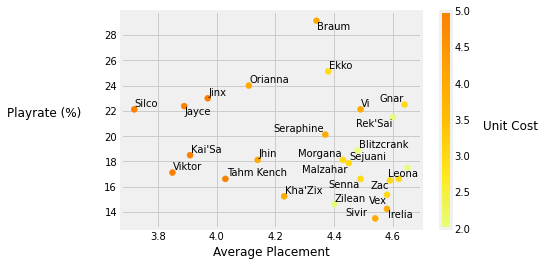

In [28]:
df = df[df['12.8 Playrate'] > mean]
placement = df['12.8 Placement'].to_numpy()
playrate = df['12.8 Playrate'].to_numpy()
cost = df['Cost'].to_numpy()
unit = df['unit'].to_numpy()
plt.scatter(placement, playrate, c=cost, cmap = 'Wistia')
bar = plt.colorbar()
bar.set_label('Unit Cost', rotation=0, labelpad=40)
plt.xlabel('Average Placement')
plt.ylabel('Playrate (%)', rotation=0, labelpad=60)
annotation_list = []
for i, text in enumerate(unit):
    annotation = plt.annotate(text, (placement[i], playrate[i]))
    annotation_list.append(annotation)
adjust_text(annotation_list)
plt.show()




Although some units such as Ekko, Blitzcrank, and Rek'sai are played frequently on end-game boards, 4 and 5 cost champiosn dominate the endgame. You can see from the plots below that endgame boards not only more popular, but also perform better on average. 

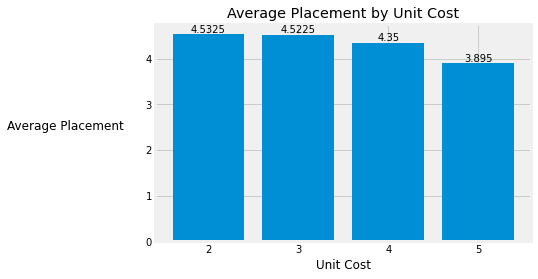

In [29]:
x = df.groupby('Cost').agg({'12.8 Placement': np.mean})
indexes = x.index.tolist()
values = x['12.8 Placement'].tolist()
fig, ax = plt.subplots()
bars = ax.bar(indexes, values)
ax.bar_label(bars)
plt.xticks([2,3,4,5])
plt.xlabel('Unit Cost')
plt.ylabel('Average Placement', rotation=0, labelpad=80)
plt.title('Average Placement by Unit Cost')
plt.show()

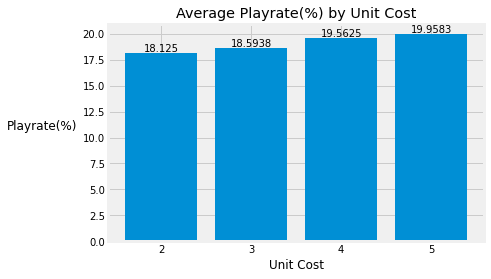

In [30]:
x = df.groupby('Cost').agg({'12.8 Playrate': np.mean})
indexes = x.index.tolist()
values = x['12.8 Playrate'].tolist()
fig, ax = plt.subplots()
bars = ax.bar(indexes, values)
ax.bar_label(bars)
plt.xticks([2,3,4,5])
plt.xlabel('Unit Cost')
plt.ylabel('Playrate(%)', rotation=0, labelpad=40)
plt.title('Average Playrate(%) by Unit Cost')
plt.show()


## Analysis of Player Data
After looking into what the metagame looked like in Patch 12.8 when it comes to units, let's take a look at how players played the patch. First, let's see how much games of TFT 12.8 was played by the top of the leaderboard.
Outside of activity, it's worth looking into how different players are faring in the patch. Let's see the top gainers and losers of the patch. Note: Abnormal gains (ex. gaining 400-500+ LP in a patch) could just be a smurf climbing to high ladder, while abnormal drops could come from accounts decaying).
### Winners and Losers of Patch 12.8

Text(0.5, 0, 'Increase in LP')

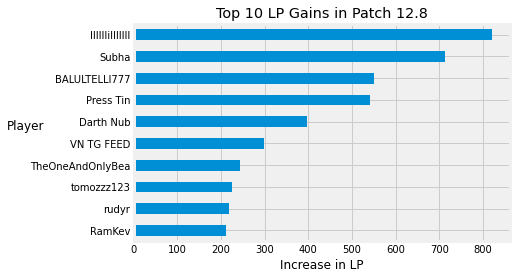

In [31]:
top_10 = full_player_data.sort_values(['patch-lp'], ascending=False)[['patch-lp','name']].head(10)
bottom_10 = full_player_data.sort_values(['patch-lp'], ascending=False)[['patch-lp', 'name']].tail(10)
make_bar_plot(top_10)
plt.title('Top 10 LP Gains in Patch 12.8')
plt.ylabel('Player', rotation=0)
plt.xlabel('Increase in LP')

In [32]:
bottom_10 = bottom_10[bottom_10['patch-lp']<0]

Text(0.5, 0, 'Decrease in LP')

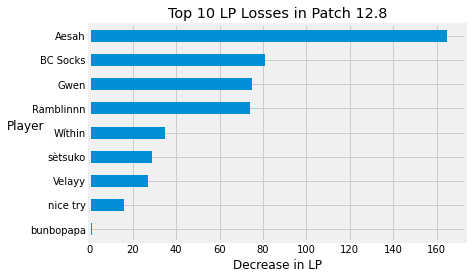

In [33]:
bottom_10['patch-lp'] = bottom_10['patch-lp'].abs()
bottom_10 = bottom_10.sort_values(by=['patch-lp'],ascending=False)
make_bar_plot(bottom_10)
plt.title('Top 10 LP Losses in Patch 12.8')
plt.ylabel('Player', rotation=0)
plt.xlabel('Decrease in LP')


### Activity in Patch 12.8


Taking a look at overall activity in the patch. The average player on the top of the leaderboard played around 38 games. A decent chunk of players (around 25%) of the players on the leaderboard played less than 20 games during the patch. However, the upper quartile of players in the leaderboard played 62 or more games. Let's see who were the most and least active players of the patch.

In [49]:
df = full_player_data.sort_values(['patch-games'], ascending=False)[['patch-games','name']]
df.columns = ['','']
df.describe().loc[['count', 'mean', 'min', 'max']]

,
count,38.000000
mean,44.131579
min,10.000000
max,106.000000


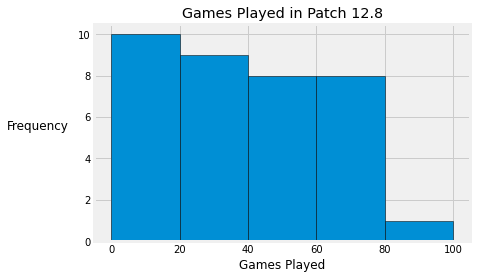

In [36]:
bins = [20*i for i in range(0,6)]
plt.ylabel('Frequency', rotation=0, labelpad=40)
plt.xlabel('Games Played')
plt.title('Games Played in Patch 12.8')
make_histogram(df, bins)



#### Most Active and Inactive Players in Patch 12.8

In [36]:
top_10 = full_player_data.sort_values(['patch-games'], ascending=False)[['patch-games','name']].head(10)
bottom_10 = full_player_data.sort_values(['patch-games'], ascending=False)[['patch-games', 'name']].tail(10)
top_10.style.hide_index()

patch-games,name
106,tapiokaoisii
101,iLoda NA
93,RamKev
77,IlIllIilllIlIl
73,Aesah
71,setsuko9
69,Subha
66,Dishsoap2
62,sètsuko
62,Amde


In [37]:
bottom_10.style.hide_index()

patch-games,name
19,FingerLicker
18,TheOneAndOnlyBea
17,CN smùrfing
16,FoemanDD
14,KurumBusinessAcc
12,tyreaal
12,9 P
11,Soda Is A Cat
10,BC Socks
10,Gwen


## Analysis of Profile Data 

We also have data on players' ratings made by tactics.tools on 5 categories: Flexibility, Econ, Items, Compositions, and Execution. Let's look at how the top players perform in each category one by one.
### Flexibility Rating of Players in 12.8
There is a lot of variety in how flexible players are. Although it is most common that players have a grade of C to A in flexibility, there are some extremely flexible and extremely unflexible players that are on the top of the leaderboard. 

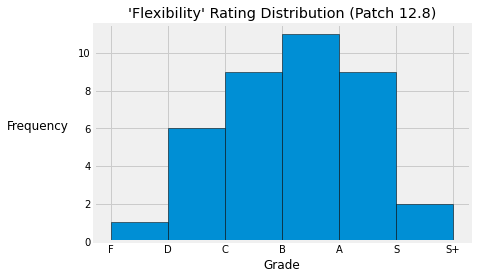

In [38]:
df = full_player_data.sort_values(['Flexibility_num'], ascending=False)[['Flexibility_num', 'name']]
bins = [i for i in range(0,7)]
plt.title('\'Flexibility\' Rating Distribution (Patch 12.8)')
plt.xticks(ticks=range(0,7),labels=['F', 'D', 'C', 'B', 'A', 'S', 'S+'])
plt.ylabel('Frequency',rotation=0, labelpad=40 )
plt.xlabel('Grade')
make_histogram(df,bins)


Deeper look, the most flexible players are   RamKev and 9 P with S-rank flexibility, while 'CN smùrfing' has shown you can make it to the top of the server even with an F in flexibility. 

#### Top 10 and Bottom 10 Flexible Players

In [39]:
top_10 = full_player_data.sort_values(['Flexibility_num'], ascending=False)[['Flexibility', 'name']].head(10)
bottom_10 = full_player_data.sort_values(['Flexibility_num'], ascending=False)[['Flexibility', 'name']].tail(10)
top_10

,Flexibility,name
36,S,9 P
15,S,RamKev
27,A,FoemanDD
2,A,Darth Nub
3,A,Subha
7,A,BestSatoJP
21,A,Ramblinnn
9,A,Triple8s
11,A,setsuko9
13,A,BC Socks


In [40]:
bottom_10

,Flexibility,name
5,C,Amde
4,C,tapiokaoisii
37,C,tomozzz123
25,D,ggopen
24,D,tyreaal
18,D,ttv NicNac19
10,D,Liquid Kurumx
32,D,BALULTELLI777
34,D,bunbopapa
8,F,CN smùrfing


#### Comparison of Units Used Between Top 10 and Bottom 10 Flexible Players
Flexible and non-flexible players must have large playstyle differences. Let's see which units fits which kind of playstyle. Less flexible players seem to use frequently make use of Jinx and Orianna, strong supports for 4-cost carries. Meanwhile, more flexible players make more use of 5-cost carries (Viktor, Kaisa) and generic frontline (Braum, Blitzcrank).

<AxesSubplot:>

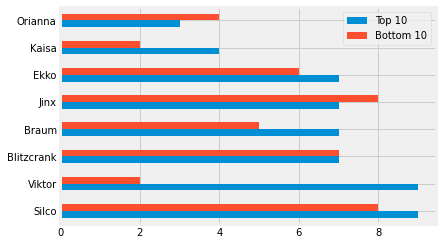

In [41]:
comparison = unit_comparison(top_10, bottom_10, preferences)
comparison.columns = ['Top 10', 'Bottom 10']
comparison = comparison[(comparison['Top 10'] >=4) | (comparison['Bottom 10'] >= 4)]
comparison.plot(kind='barh')
plt.xlabel('# of Players Using Unit')
plt.ylabel('Unit')
plt.show()

### Execution Rating of Players in 12.8
A look at the 'execution rating' of top players in 12.8. All players have a grade of A or better, shows that you need to execute well and be efficient to perform well on the ladder. No need to look into the difference in unit plays if players have overalll similar ratings. 

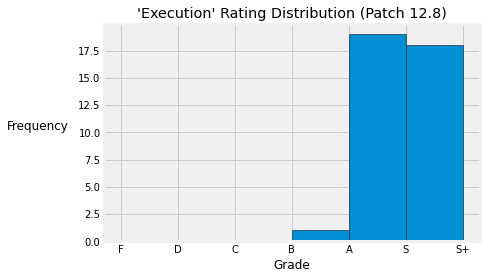

In [42]:
df = full_player_data.sort_values(['Execution_num'], ascending=False)[['Execution_num', 'name']]
bins = [i for i in range(0,7)]
plt.title('\'Execution\' Rating Distribution (Patch 12.8)')
plt.xticks(ticks=range(0,7),labels=['F', 'D', 'C', 'B', 'A', 'S', 'S+'])
plt.ylabel('Frequency',rotation=0, labelpad=40 )
plt.xlabel('Grade')
make_histogram(df,bins)

### Econ Rating of Players in 12.8
Similar story for the 'Econ' rating. All players have a grade rating of A or better. This may change in other patches, but it shows that having a strong economy is important to placing well in the patch. Similar to the 'Execution Rating' no need to look into difference of units used if ratings are similar. 

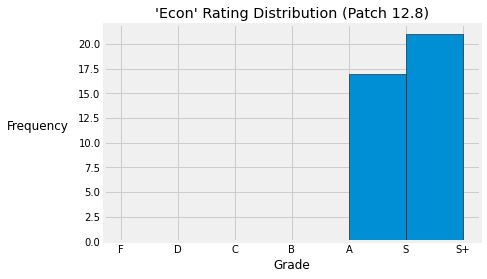

In [43]:
df = full_player_data.sort_values(['Econ_num'], ascending=False)[['Econ_num', 'name']]
bins = [i for i in range(0,7)]
plt.title('\'Econ\' Rating Distribution (Patch 12.8)')
plt.xticks(ticks=range(0,7),labels=['F', 'D', 'C', 'B', 'A', 'S', 'S+'])
plt.ylabel('Frequency',rotation=0, labelpad=40 )
plt.xlabel('Grade')
make_histogram(df,bins)

### Composition Rating of Players in 12.8
Applies even more for 'Compositions' Rating, everyone either has an S or S+ in compositions. It is a requirement to play strong compositions in the meta to do well on the ladder (at least in Patch 12.8). 

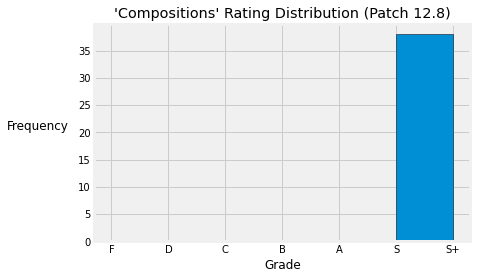

In [44]:
df = full_player_data.sort_values(['Compositions_num'], ascending=False)[['Compositions_num', 'name']]
bins = [i for i in range(0,7)]
plt.title('\'Compositions\' Rating Distribution (Patch 12.8)')
plt.xticks(ticks=range(0,7),labels=['F', 'D', 'C', 'B', 'A', 'S', 'S+'])
plt.ylabel('Frequency',rotation=0, labelpad=40 )
plt.xlabel('Grade')
make_histogram(df,bins)

### Items Rating of Players in 12.8
More differences are seen in players 'Items' rating. Some players are more reliant on having the best items for all of their units, while others may not have optimal items, but gain advantage elsewhere (ex. slamming items early to save HP). An example would be 'CN smùrfing', who has an S in items, but an F in flexibility. It is possible that since he is less flexible with what units he plays, he can focus on making only the best items for his comp of choice. 

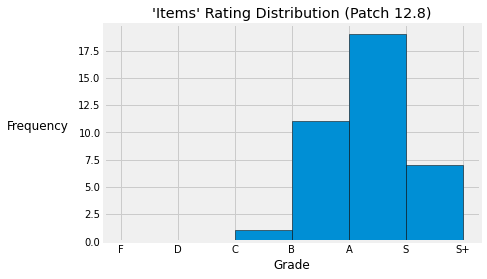

In [45]:
df = full_player_data.sort_values(['Items_num'], ascending=False)[['Items_num', 'name']]
bins = [i for i in range(0,7)]
plt.title('\'Items\' Rating Distribution (Patch 12.8)')
plt.xticks(ticks=range(0,7),labels=['F', 'D', 'C', 'B', 'A', 'S', 'S+'])
plt.ylabel('Frequency',rotation=0, labelpad=40 )
plt.xlabel('Grade')
make_histogram(df,bins)

#### Top 10 and Bottom 10 Players by 'Items' Rating

In [46]:
top_10 = full_player_data.sort_values(['Items_num'], ascending=False)[['Items', 'name']].head(10)
bottom_10 = full_player_data.sort_values(['Items_num'], ascending=False)[['Items', 'name']].tail(10)
top_10

,Items,name
14,S,Gwen
8,S,CN smùrfing
23,S,Soda Is A Cat
32,S,BALULTELLI777
1,S,Wíthin
27,S,FoemanDD
3,S,Subha
36,A,9 P
7,A,BestSatoJP
26,A,Press Tin


In [47]:
bottom_10

,Items,name
0,B,sètsuko
28,B,FingerLicker
24,B,tyreaal
22,B,nice try
20,B,Aesah
13,B,BC Socks
11,B,setsuko9
6,B,Dishsoap2
19,B,rudyr
18,C,ttv NicNac19


We can see what units are used by players who prioritize items, compared to thoose who don't prioritize it as much. Those who prioritize items seem to heavily prefer the Scrap core of Jinx and Ekko. Ekko in particular is really strong specifically with the item Frozen Heart. Meanwhile, players who don't prioritize items focus on units support units that can perform well regardless of items, such as Jhin, Orianna, and Braum. 

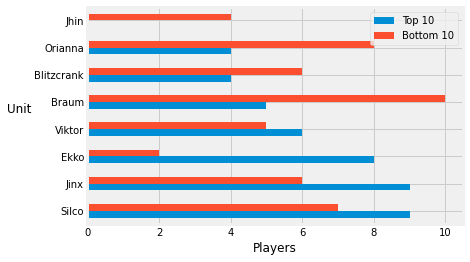

In [51]:
comparison = unit_comparison(top_10, bottom_10, preferences)
comparison.columns = ['Top 10', 'Bottom 10']
comparison = comparison[(comparison['Top 10'] >=4) | (comparison['Bottom 10'] >= 4)]
comparison.plot(kind='barh')
plt.xlabel('Players')
plt.ylabel('Unit', rotation=0, labelpad=15)
plt.show()

#### Case Study: CN smùrfing
'CN smùrfing' had by far the most polarizing profile, with a Flexibility rating of F, and an items rating of S. What units does he play the most? It appears he mostly plays the Scrap Sivir comp, a unit most often seen at the world championships, played in Patch 12.7. It appears to still be very strong in this patch, to the point that someone can be near the top of the NA leaderboard forcing the comp.


In [60]:
user = preferences[preferences['name'] == 'CN smùrfing']
user.columns = ['','','','','','','','']
user

,,,,,,,,
6,CN smùrfing,Ekko,Blitzcrank,Irelia,Sivir,Gnar,Jinx,Braum
